In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os
%matplotlib inline
np.random.seed(1)

### 1. Load Data

In [2]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [10]:
def load_data():
    num_classes=10
    path = "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/USPS_dataset/usps.h5"
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y_tr = convert_to_onehot(y_tr,num_classes)
    y_te = convert_to_onehot(y_te,num_classes)
    X_tr = np.array(X_tr).reshape(len(X_tr),16,16)
    X_te = np.array(X_te).reshape(len(X_te),16,16)
        
    return X_tr, y_tr, X_te, y_te
    

In [11]:
X_train, y_train, X_test, y_test = load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

### 2. Dimension Check


In [12]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
# plt.imshow(X_train[0])

(2007, 16, 16, 1)
(7291, 16, 16, 1)
(2007, 10)
(7291, 10)


### 3 -  Tensorflow Forward Pass


In [13]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [14]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [15]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    #Conv2d
#     print(X.shape)
#     print(W1.shape)
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
#     print(Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
#     print(A1.shape)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
#     print(P1.shape)
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
#     print(Z2.shape)
    # RELU
    A2 = tf.nn.relu(Z2)
#     print(A2.shape)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')
    # FLATTEN
#     print(P2.shape)
    P2 = tf.contrib.layers.flatten(P2)
#     print(P2.shape)
    # FULLY-CONNECTED 
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
#     print(Z3.shape)

    return Z3

### 6 - Compute Cost

In [16]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [17]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [21]:
import time
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 150, minibatch_size = 200, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        tr_start_time = time.time()
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        tr_end_time = time.time()
        
        te_start_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        te_end_time = time.time()
        print("Training Time: "+ str(tr_end_time - tr_start_time) + " sec")
        print("Train Accuracy:", train_accuracy)
        print("Testing Time: "+ str(te_end_time - te_start_time) + " sec")
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [22]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    _, _, parameters = f(*args)
    toc = time.time()
    return toc - tic

Cost after epoch 0: 2.433919
Cost after epoch 5: 1.834705
Cost after epoch 10: 0.669486
Cost after epoch 15: 0.402979
Cost after epoch 20: 0.309441
Cost after epoch 25: 0.256116
Cost after epoch 30: 0.221081
Cost after epoch 35: 0.198308
Cost after epoch 40: 0.180965
Cost after epoch 45: 0.164561
Cost after epoch 50: 0.152914
Cost after epoch 55: 0.143842
Cost after epoch 60: 0.137594
Cost after epoch 65: 0.129679
Cost after epoch 70: 0.121923
Cost after epoch 75: 0.115239
Cost after epoch 80: 0.110647
Cost after epoch 85: 0.107771
Cost after epoch 90: 0.102513
Cost after epoch 95: 0.101572
Cost after epoch 100: 0.095982
Cost after epoch 105: 0.094143
Cost after epoch 110: 0.090810
Cost after epoch 115: 0.088991
Cost after epoch 120: 0.086904
Cost after epoch 125: 0.084407
Cost after epoch 130: 0.082140
Cost after epoch 135: 0.078756
Cost after epoch 140: 0.080373
Cost after epoch 145: 0.077032


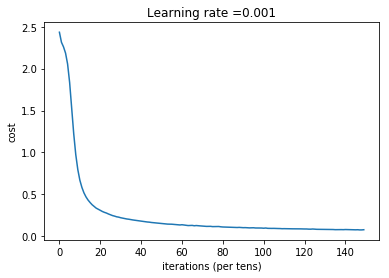

Training Time: 88.11384987831116 sec
Train Accuracy: 0.9786038
Testing Time: 0.06130790710449219 sec
Test Accuracy: 0.9337319


In [23]:
execution_time = time_function(model, X_train, y_train, X_test, y_test)

In [24]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 88.54319214820862 sec
